In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

seed = 71
np.random.seed = seed
algorithm_globals.random_seed = seed

In [3]:
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, SLSQP

n = 2
mu = 2**(n-1)
sigma = 1
number_of_training_sample = 1000
real_data = np.random.normal(mu, sigma, size=number_of_training_sample)


num_qubits = [n]
bounds = [0, 2**n-1]
num_epochs = 300
batch_size = 100


qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed)

# Set entangler map

# Set an initial state for the generator circuit as a uniform distribution
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement='linear', reps=1)

init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/var/folders/26/bfg4nt4s0f17qx8ryxwcpmsw0000gn/T/ipykernel_53463/457904912.py:24: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


In [12]:
# Run qGAN for "number_of_trial" runs and find the best trial with the minimum relative entropy
# IT TAKES 256m 50s
result_set = {}
number_of_trial = 50
for trial in range(number_of_trial):
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
    result = qgan.run(quantum_instance)
    result_set[trial] = [result['params_g'], result['rel_entr']]
    print(trial, result['rel_entr'])
    trial += 1
    
minimum_relative_entropy_trial = 0
for trial in range(number_of_trial):
    if(result_set[trial][1] < result_set[minimum_relative_entropy_trial][1]): 
        minimum_relative_entropy_trial = trial

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=result_set[minimum_relative_entropy_trial][0])
result = qgan.run(quantum_instance)

0 0.3722
1 0.3214
2 0.5302
3 0.0222
4 0.0853
5 0.5034
6 0.0394
7 0.3013
8 0.4678
9 0.0031
10 0.1507
11 0.6288
12 0.4924
13 0.6175
14 0.4127
15 0.4852
16 0.3967
17 0.5563
18 0.1641
19 0.6482
20 0.3374
21 0.7965
22 0.0845
23 0.1975
24 0.3157
25 1.0311
26 0.1203
27 0.3269
28 0.2295
29 0.9404
30 0.486
31 0.2808
32 0.2761
33 0.1241
34 0.2914
35 0.0246
36 0.4298
37 0.158
38 0.4509
39 0.5297
40 0.0788
41 0.2128
42 0.608
43 0.5353
44 0.0522
45 0.0237
46 0.0985
47 0.0049
48 0.2886
49 0.5227


In [20]:
minimum_relative_entropy_trial

9

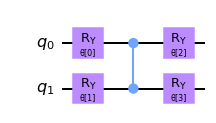

In [13]:
ansatz.decompose().draw('mpl')

In [14]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [ 0.06130932  0.1066487  -0.02349196 ...  0.01410263 -0.01831192
 -0.0111932 ]
  params_g : [2.97021207 2.7793179  5.70570352 0.13061101]
  loss_d : 0.6931
  loss_g : [0.6945]
  rel_entr : 0.0033


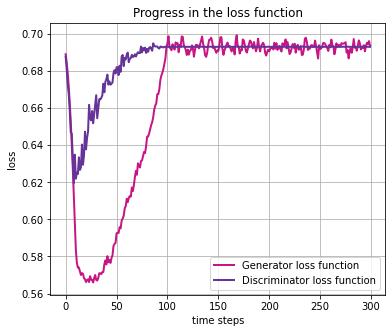

In [27]:
# Plot progress w.r.t the generator's and the discriminator's loss function
initial = num_epochs*minimum_relative_entropy_trial
final = num_epochs*(minimum_relative_entropy_trial+1)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss[initial:final], label="Generator loss function", color="mediumvioletred", linewidth=2)
plt.plot(t_steps, qgan.d_loss[initial:final], label="Discriminator loss function", color="rebeccapurple", linewidth=2)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

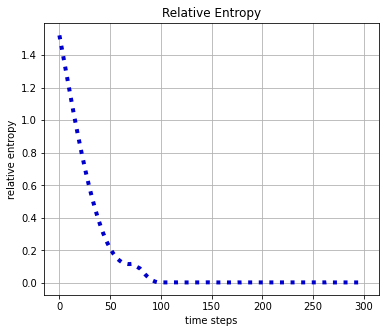

In [28]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr[initial:final])), qgan.rel_entr[initial:final], color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

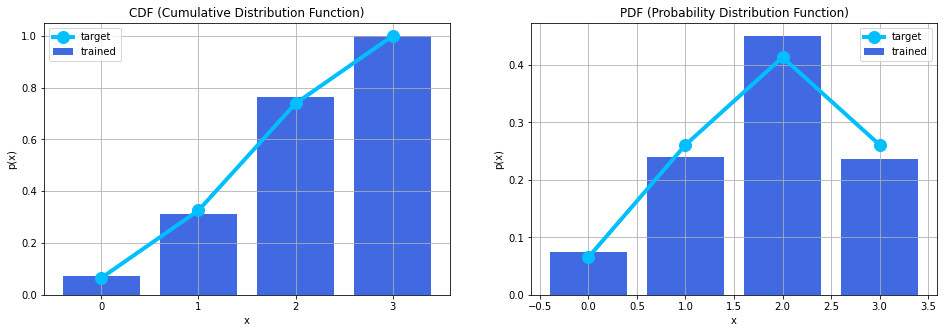

In [19]:
# # Plot the CDF of the resulting distribution against the target distribution, i.e. log-gaussian
gaussian = np.random.normal(mu, sigma, size=10000000)
gaussian = np.round(gaussian)
gaussian = gaussian[gaussian >= bounds[0]]
gaussian = gaussian[gaussian <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(gaussian == i)]
gaussian = np.array(temp / sum(temp))



plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title("CDF (Cumulative Distribution Function)")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g, np.cumsum(prob_g), color="royalblue", width=0.8, label="trained")
plt.plot(np.cumsum(gaussian), "-o", label="target", color="deepskyblue", linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0))
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title('PDF (Probability Distribution Function)')
plt.bar(samples_g,  prob_g, color='royalblue', width=0.8, label='trained')
plt.plot((gaussian), '-o', label='target', color='deepskyblue', linewidth=4, markersize=12)
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()